# Convergence of the mappings

Study the numerical convergence of mappings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl, matplotlib.pyplot as plt
import numpy as np
from neurodyn import *

LowRankRNN{N=20000, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=True}


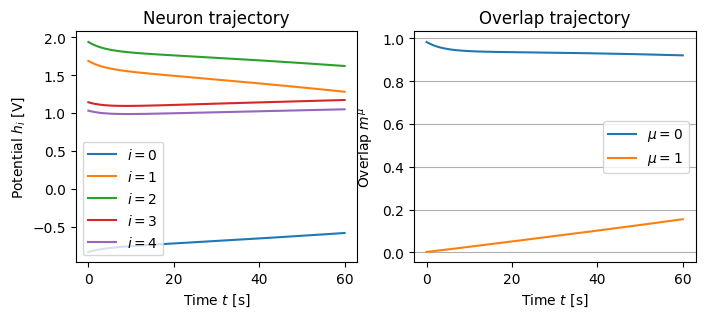

In [55]:
rnn = LowRankRNN.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
res = rnn.simulate(rnn.F[:, 0], (0, 60), dt_max=0.4, progress=True, cache=True)
print(rnn)
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
plot_neuron_trajectory(res, figax=(fig, axes[0]));
plot_overlap_trajectory(rnn, res, figax=(fig, axes[1]));

In [16]:
# TODO : sort the dense matrix according to connectivity

In [53]:
def binned_index_connectivity_naive(rnn: LowRankRNN, n: int, bin_index: np.ndarray) -> np.ndarray:
	# a naive implementation to test things out, slow !!
	from tqdm import tqdm
	
	_, bin_index_count = np.unique(bin_index, return_counts=True)
	J = np.zeros((4**n, 4**n), dtype=float)

	for i in tqdm(range(rnn.N)):
		for j in range(rnn.N):
			if i == j: continue
			J[bin_index[i], bin_index[j]] += (rnn.F[i] * rnn.G[j]).sum()

	J /= rnn.N

	for alpha in range(4):
		J[alpha, :] /= bin_index_count[alpha]

	return J


def binned_index_connectivity(rnn: LowRankRNN, n: int, bin_index: np.ndarray) -> np.ndarray:
	_, bin_index_count = np.unique(bin_index, return_counts=True)
	J = np.zeros((4**n, 4**n), dtype=float)

	for alpha in range(4**n):
		for beta in range(4**n):
			J[alpha, beta] += np.einsum('im,jm->', rnn.F[bin_index == alpha, :], rnn.G[bin_index == beta, :])
			if alpha == beta:  # exclude self connections
				J[alpha, beta] -= np.einsum('im,im->', rnn.F[bin_index == alpha, :], rnn.G[bin_index == beta, :])
		J[alpha, :] /= bin_index_count[alpha]
		
	J /= rnn.N

	return J

In [54]:
rnn = LowRankRNN.new_valentin(p=2, N=1000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
n = 1
mapping = recursive_quadrant_mapping(rnn.F, n)
bin_index = (mapping * 4**n).astype(int)

print('-- naive method --')
print(binned_index_connectivity_naive(rnn, n, bin_index))

print('-- fast method --')
print(binned_index_connectivity(rnn, n, bin_index))

-- naive method --


100%|██████████| 1000/1000 [00:10<00:00, 98.42it/s]

[[ 1.45119276  0.28966982 -1.98461211  0.33203223]
 [ 0.22657076  1.73885271 -0.2716881  -1.66248461]
 [-1.03859207 -0.20251376  1.40162736 -0.23897197]
 [ 0.18679833 -1.6010005  -0.28783173  1.68041624]]
-- fast method --
[[ 1.45119276  0.28966982 -1.98461211  0.33203223]
 [ 0.22657076  1.73885271 -0.2716881  -1.66248461]
 [-1.03859207 -0.20251376  1.40162736 -0.23897197]
 [ 0.18679833 -1.6010005  -0.28783173  1.68041624]]
